# [experimental] WebDataset integration

This notebook shows how to write a dataloading pipeline for ASR using mini LibriSpeech dataset leveraging Lhotse's WebDataset integration. 

The WebDataset project helps to speed-up reading data from disks or network. They way its used in Lhotse is that we package the meta-data (cuts) along with binary data (audio, features, etc.) into tar files, which can be read much faster this way. This is because we perform sequential reads rather than random reads in typical Lhotse workflows, so we need to open the file handle only once, and make it easier for the disk/OS caching and prefetching to anticipate what we're going to read next.

This step requires you to make a full copy of your data, so note that there is a storage size / performance trade-off to it.

Find out more about the WebDataset project here: https://github.com/webdataset/webdataset

In [1]:
# Optional auto-formatting

#!pip install nb_black
#%load_ext lab_black

In [2]:
# Get the latest version of Lhotse, if not installed:

#!pip install git+https://github.com/lhotse-speech/lhotse

In [3]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from lhotse import CutSet, Fbank, RecordingSet
from lhotse.dataset import (
    CutMix,
    DynamicBucketingSampler,
    K2SpeechRecognitionDataset,
    OnTheFlyFeatures,
    PerturbSpeed,
    PerturbVolume,
    RandomizedSmoothing,
    ReverbWithImpulseResponse,
    SpecAugment,
)
from lhotse.recipes import (
    download_librispeech,
    prepare_librispeech,
)

In [4]:
root_dir = Path("data")
tmp_dir = Path("tmp")
tmp_dir.mkdir(exist_ok=True)
num_jobs = os.cpu_count() - 1

# (mini) LibriSpeech

We're downloading the data, preparing recording/supervision manfiests, and compiling them into CutSets. 
A cut is a basic "example" of data in Lhotse.

Approx. download size 450MB.

In [5]:
# libri_variant = "librispeech"
libri_variant = "mini_librispeech"
libri_root = download_librispeech(root_dir, dataset_parts=libri_variant)
libri = prepare_librispeech(
    libri_root, dataset_parts=libri_variant, output_dir=root_dir, num_jobs=num_jobs
)
cuts_train = CutSet.from_manifests(**libri["train-clean-5"]).trim_to_supervisions()
cuts_dev = CutSet.from_manifests(**libri["dev-clean-2"]).trim_to_supervisions()

Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

# Export cuts to WebDataset tar file shards

Sharding is a technique used to partition a large dataset into smaller parts that can be split between different GPU nodes and dataloading workers.

In this example, we're working with small data, but we'll treat it like a large dataset to illustrate the typical usage.

In [6]:
from lhotse.dataset.webdataset import export_to_webdataset

# We'll keep the audio in SPHERE format to reduce its size.
# We can also use "flac" but it may require setting torchaudio.set_audio_backend("soundfile"),
# as we observed the "sox_io" backend FLAC decoder tends to fail sometimes with in-memory buffers.
export_to_webdataset(
    cuts_train,
    output_path=f"{tmp_dir}/shard-%d.tar",
    shard_size=300,
    audio_format="sph",
)

# writing tmp/shard-0.tar 0 0.0 GB 0


Creating WebDataset tarball(s):   0%|          | 0/1519 [00:00<?, ?it/s]

# writing tmp/shard-1.tar 300 0.2 GB 300
# writing tmp/shard-2.tar 300 0.2 GB 600
# writing tmp/shard-3.tar 300 0.3 GB 900
# writing tmp/shard-4.tar 300 0.2 GB 1200
# writing tmp/shard-5.tar 300 0.2 GB 1500


6

# Reading WebDataset-stored CutSet+data

We list the shards and give the list to function `CutSet.from_webdataset`. We can also pass a single shard, a url, or a bash command. 

It's possible to read from cloud storage this way, e.g. `'pipe:aws s3 cp s3://my-bucket/shard-1.tar -'` would spawn an S3 reading subprocess from which we'll read the data.

The meaning of extra arguments in `from_webdataset` function is explained in the next paragraph.

In [7]:
shards = [str(path) for path in sorted(tmp_dir.glob("shard-*.tar"))]
print(shards)
cuts_train_webdataset = CutSet.from_webdataset(
    shards,
    split_by_worker=True,
    split_by_node=True,
    shuffle_shards=True,
)
print(cuts_train_webdataset)

['tmp/shard-0.tar', 'tmp/shard-1.tar', 'tmp/shard-2.tar', 'tmp/shard-3.tar', 'tmp/shard-4.tar', 'tmp/shard-5.tar', 'tmp/shard-writer-0.tar']
CutSet(len=<unknown>) [underlying data type: <class 'lhotse.dataset.webdataset.LazyWebdatasetIterator'>]


# Training DataLoader with WebDataset

Since WebDataset approach uses sharding for data de-duplication across multiple DataLoader workers and GPU nodes,
we need to adjust how we create the DataLoader. 

We'll extend the "base" approach used in `examples/00-basic-workflow.ipynb` (next to this file).
The code below has the same functionality, just reads the data differently.

The main change is that we create an IterableDataset, which is just a wrapper over sampler iteration and map-style dataset that converts CutSet mini-batch to tensors.
What this does is it moves the sampler to dataloading worker processes, so WebDataset can "auto-detect" that its in a multi-worker context and can drop some shards in each worker/node. Remember that in a "typical" sampler + map-style dataset scenario, the sampler lives in the same process as the main training loop instead.

To learn more about map-style and iterable-style datasets, see: https://pytorch.org/docs/stable/data.html#dataset-types

In [8]:
train_sampler = DynamicBucketingSampler(
    cuts_train_webdataset,  # <-- note the "_webdataset" variant being used here
    shuffle=True,
    max_duration=100.0,
    num_buckets=10,
)

train_dataset = K2SpeechRecognitionDataset(
    cut_transforms=[
        PerturbSpeed(factors=[0.9, 1.1], p=2 / 3),
        PerturbVolume(scale_low=0.125, scale_high=2.0, p=0.5),
    ],
    input_transforms=[
        SpecAugment(),  # default configuration is well-tuned
    ],
    input_strategy=OnTheFlyFeatures(Fbank()),
)

# This is the part that's different:
from lhotse.dataset.iterable_dataset import IterableDatasetWrapper

train_iter_dataset = IterableDatasetWrapper(
    dataset=train_dataset,
    sampler=train_sampler,
)

train_dloader = DataLoader(
    train_iter_dataset,
    batch_size=None,
    num_workers=0,  # For faster dataloading, use num_workers > 1
)

### High-level architecture of the solution


```
┌────────────────────────────────────────────────────────────────────────┐ 
│┌──────────────────────────────────────────────────────────────────────┐│ 
││                            Training loop                             ││ 
│└──────────────────────────────────────────────────────────────────────┘│ 
│                                    │                                   │ 
│                                    ▼                                   │ 
│                     ┌─────────────────────────────┐                    │ 
│                     │ torch.utils.data.DataLoader │                    │ 
│                     └─────────────────────────────┘        Main process│ 
└────────────────────────────────────┬───────────────────────────────────┘ 
       ┌─────────────────────────────┼───────────────────────────────┐     
       ▼       ┌─────────────────────▼───────────────────────┐       ▼     
  ┌─────────┐  │                ┌─────────┐   Sub-process #i │  ┌─────────┐
  │Worker #1│  │                │Worker #i│                  │  │Worker #N│
  └─────────┘  │                └─────────┘                  │  └─────────┘
               │                     │                       │             
               │                     ▼                       │             
               │        ┌────────────────────────┐           │             
               │        │ IterableDatasetWrapper │           │             
               │        └────────────────────────┘           │             
               │                     │                       │             
               │           ┌─────────┴──────┐                │             
               │           ▼                ▼                │             
               │  ┌─────────────────┐ ┌───────────┐          │             
               │  │Map-style Dataset│ │  Sampler  │          │             
               │  │ (task-specific) │ │           │          │             
               │  └─────────────────┘ └───────────┘          │             
               │                            │                │             
               │                            ▼                │             
               │                      ┌───────────┐          │             
               │                      │  CutSet   │          │             
               │                      └───────────┘          │             
               │                            │                │             
               │                            ▼                │             
               │               ┌────────────────────────┐    │             
               │               │Lazy WebDataset Iterator│    │             
               │               │(discards shard_idx % N)│    │             
               │               └────────────────────────┘    │             
               │                            │                │             
               │                ┌───────────┼───────────┐    │             
               │                ▼           ▼           ▼    │             
               │           ┌────────┐  ┌────────┐  ┌────────┐│             
               │           │Shard #1│  │Shard #j│  │Shard #M││             
               │           └────────┘  └────────┘  └────────┘│             
               └─────────────────────────────────────────────┘             
```

### Visualisation

We simply iterate the dataloader as usual and view how the first batch looks like

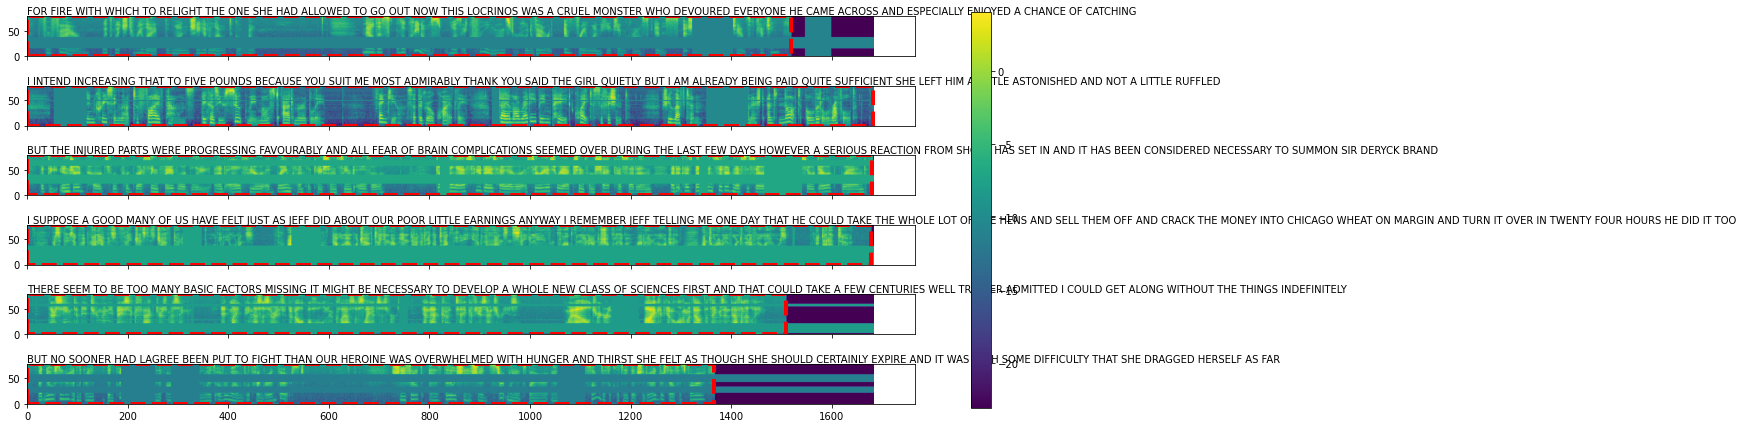

In [9]:
from lhotse.dataset.vis import plot_batch

for batch in train_dloader:
    plot_batch(batch)
    break

# Basic benchmark

## Random read version

In [10]:
for cut in tqdm(cuts_train):
    cut.load_audio()

  0%|          | 0/1519 [00:00<?, ?it/s]

## Sequential read version

Note: this would get even faster if the shards are bigger, we used 300 just for illustrations since mini LibriSpeech has only 1500 training utterances.

In [11]:
for cut in tqdm(cuts_train_webdataset):
    cut.load_audio()

0it [00:00, ?it/s]

# Lower-level exporting API

If you want to do additional filtering or compute something extra and add it to features while exporting, you can use `WebdatasetWriter` instead of `export_to_webdataset`:

In [12]:
from lhotse.dataset.webdataset import WebdatasetWriter
from lhotse.features.io import MemoryRawWriter
from torchaudio.functional import compute_kaldi_pitch

with WebdatasetWriter(
    f"{tmp_dir}/shard-writer-%d.tar", shard_size=300, audio_format="sph"
) as tar_writer:
    for cut in tqdm(cuts_train):
        if cut.duration > 5.0:
            # skip some cuts
            continue

        # Move audio data to memory so that we avoid loading it twice
        cut = cut.move_to_memory(audio_format="sph")

        # Compute pitch features with an external library, i.e., torchaudio.
        # Note: snip_edges=False makes the number of frames consistent with what Lhotse typically expects,
        # but is not strictly required here.
        pitch_feats = compute_kaldi_pitch(
            torch.from_numpy(cut.load_audio()),
            sample_rate=cut.sampling_rate,
            snip_edges=False,
        ).squeeze(0)

        # Attach pitch features as a custom field to Cut -- it will be persisted when read again.
        # We're using MemoryRawWriter which converts numpy arrays into binary data.
        # That data will be stored together with the cut and audio in the tarfile.
        # Frame shift is the default for Kaldi pitch features.
        cut.pitch = MemoryRawWriter().store_array(
            cut.id, pitch_feats.numpy(), frame_shift=0.01, temporal_dim=0
        )

        # Writes the cutset with in-memory data into tar files.
        tar_writer.write(cut)

# writing tmp/shard-writer-0.tar 0 0.0 GB 0


  0%|          | 0/1519 [00:00<?, ?it/s]

In [13]:
# Check that writing was successful
shards = [str(path) for path in sorted(tmp_dir.glob("shard-writer-*.tar"))]
print(shards)

# Note lack of extra args -- we're just going to iterate over the cutset, so we don't need
# WebDataset to do de-duplication.
cuts = CutSet.from_webdataset(shards)

for cut in tqdm(cuts):
    audio = cut.load_audio()
    pitch = cut.load_pitch()

print(audio.shape)
print(pitch.shape)

['tmp/shard-writer-0.tar']


0it [00:00, ?it/s]

(1, 63760)
(399, 2)
